In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [4]:
def normalize_angle(angle):
    while (angle > math.pi):
        angle = angle - 2*math.pi
    while (angle < -math.pi):
        angle = angle + 2*math.pi
    return angle

def sample_normal_distribution(b):
    return (b/6.0)*sum([random.uniform(-1, 1) for i in range(0, 12)])

def sample_triangular_distribution(b):
    return b * random.uniform(-1, 1) * random.uniform(-1, 1)

class MotionModel:
    pass

class OdometryMotionModel:
    def __init__(self, pose):
        self.pose = np.copy(pose)   
        
    @property
    def pose(self):
        return self.pose
    
    @pose.setter
    def pose(self, new_pose):
        self.pose = np.copy(new_pose)
    
    @pose.deleter
    def pose(self):
        self.pose = None
        del self.pose
        
    def command(self, command):
        rot1 = command[0]
        trans = command[1]
        rot2 = command[2]
        
        theta_old = normalize_angle(self.pose.item(2))
        
        update_vec = np.matrix([
            trans*math.cos(theta_old + rot1),
            trans*math.sin(theta_old + rot1),
            rot1 + rot2
        ]).T
        
        self.pose = self.pose + update_vec
        
        return self.pose
    
    @staticmethod
    def sample(pose, command, noise, sample=None):
        if not sample:
            raise ValueError("Provide a sampler")
        
        rot1 = command[0]
        trans = command[1]
        rot2 = command[2]
        
        a1, a2, a3, a4 = noise
        theta_old = normalize_angle(pose.item(2))
        
        rot1_h = rot1 - sample(a1*rot1 + a2*trans)
        trans_h = trans - sample(a3*trans + a4*(rot1+rot2))
        rot2_h = rot2 - sample(a1*rot2+a2*trans)
        
        update_vec = np.matrix([
            trans_h*math.cos(theta_old + rot1_h),
            trans_h*math.sin(theta_old + rot1_h),
            rot1_h + rot2_h
        ]).T
        
        return pose + update_vec

        
class BaseRobot:
    def __init__(self, x, y, theta, motion_model=None):
        self.pose = np.matrix([x, y, theta]).T
        self.motion = motion_model
    
    @property
    def pose(self):
        return self.pose
    
    @pose.setter
    def pose(self, new_pose):
        self.pose = np.copy(new_pose)
    
    @pose.deleter
    def pose(self):
        self.pose = None
        del self.pose
    
    @property
    def motion(self):
        return self.motion
    
    @motion.setter
    def motion(self, motion_model):
        self.motion = motion_model
    
    @motion.deleter
    def motion(self):
        del self.motion
        
    def motion_command(self, command):
        self.pose = self.motion.command(command)

In [5]:
def read_data(filename):
    odometry = []
    sensor = []
    
    with open(filename, 'r') as f:
        for line in f:
            data = line.strip().split(" ")
        
            if data[0] == "ODOMETRY":
                # rotation1, translation, rotation2
                data[1:] = [float(d) for d in data[1:]]
                odometry.append(tuple(data[1:]))
            elif data[0] == "SENSOR":
                # id
                data[1] = int(data[1])
                # range, bearing
                data[2:] = [float(d) for d in data[2:]]
                
                sensor.append(tuple(data[1:]))
    
    return odometry, sensor

In [6]:
def read_world(filename):
    landmarks = []
    
    with open(filename, 'r') as f:
        for line in f:
            data = line.strip().split(" ")
            data[0] = int(data[0])
            data[1:] = [float(d) for d in data[1:]]
            
            landmarks.append(tuple(data))
    
    return landmarks

In [7]:
class ParticleFilterMotionOnly:
    '''
        One particle contains pose information only
    '''
    def __init__(self, init_pose, motion_model=None, samples=500):
        self.samples = samples
        self.motion_model = motion_model
        self.init_pose = np.copy(init_pose)
        self.particles = []
    
    def step(self, command, noise, sampler):
        
        if len(self.particles) == 0:
            for i in range(0, self.samples):
                m = self.init_pose
                particle = motion_model.sample(m, command, noise, sampler)
                self.particles.append(particle)
            return self.particles
        
        new_particles = []
        for m in self.particles:
            particle = motion_model.sample(m, command, noise, sampler)
            new_particles.append(particle)
            
        self.particles = new_particles[:]
        return self.particles

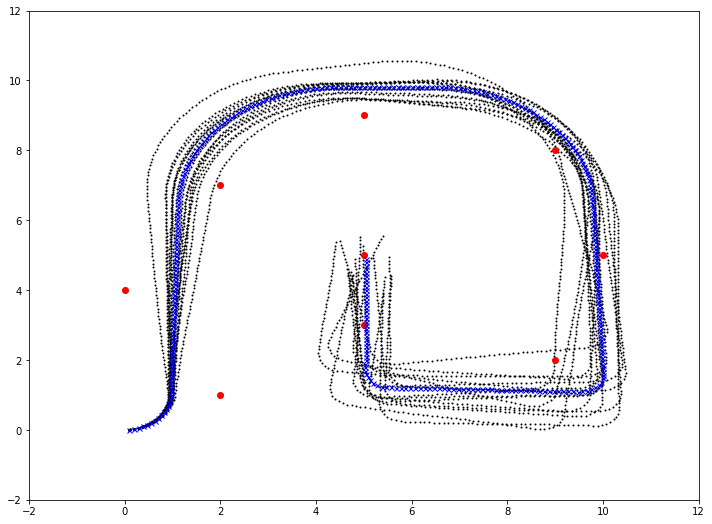

In [8]:
robot = BaseRobot(0, 0, 0)
motion_model = OdometryMotionModel(robot.pose)
robot.motion = motion_model

odometry, sensor = read_data('./data/simple/sensor_data.dat')
landmarks = read_world('./data/simple/world.dat')

commands = [np.array(odom).T for odom in odometry]

noise = [0.12, 0.12, 0.12, 0.12]

particle_filter = ParticleFilterMotionOnly(robot.pose, robot.motion, samples=16)

# Plot true robot path
x = []
y = []
particles_x = []
particles_y = []

plt.figure(figsize=(12, 9))
plt.xlim((-2, 12))
plt.ylim((-2, 12))


for landmark in landmarks:
    plt.plot(landmark[1], landmark[2], 'ro')

for command in commands:  
    particles = particle_filter.step(command, noise, sample_normal_distribution)
    
    for particle in particles:
        particles_x.append(particle.item(0))
        particles_y.append(particle.item(1))
        
    robot.motion_command(command)
    
    x.append(robot.pose.item(0))
    y.append(robot.pose.item(1))
    
plt.plot(x, y, 'bx', markersize=5, zorder=2)
plt.plot(particles_x, particles_y, 'ko', markersize=1, zorder=1)

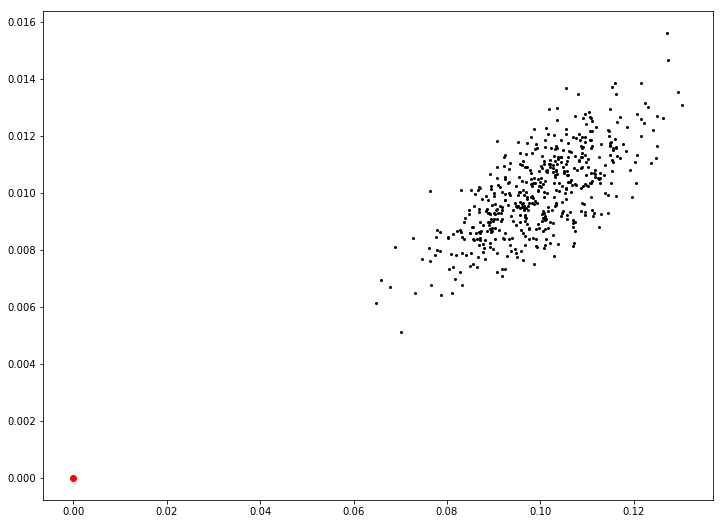

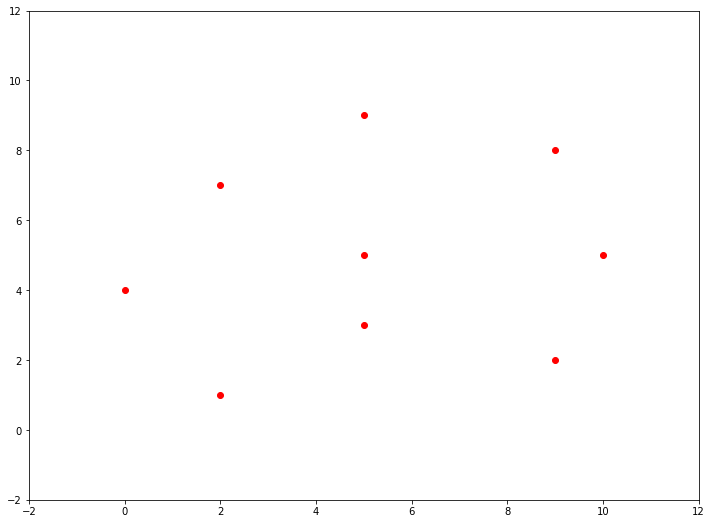

In [9]:
robot = BaseRobot(0, 0, 0)
motion_model = OdometryMotionModel(robot.pose)
robot.motion = motion_model

odometry, sensor = read_data('./data/simple/sensor_data.dat')
landmarks = read_world('./data/simple/world.dat')

commands = [np.array(odom).T for odom in odometry]
noise = [0.16, 0.16, 0.16, 0.16]

# Odometry model sampling example
x_sampled = []
y_sampled = []
samples = 500

plt.figure(figsize=(12, 9))
plt.plot(0, 0, 'ro')

pf_sampling = ParticleFilterMotionOnly(robot.pose, robot.motion, samples)
pf_particles = pf_sampling.step(commands[0], noise, sample_normal_distribution)

for sampled_pose in pf_particles:
    x_sampled.append(sampled_pose.item(0))
    y_sampled.append(sampled_pose.item(1))
    
plt.plot(x_sampled, y_sampled, 'ko', markersize=2)

# Plot true robot path and sampled approximations
x = []
y = []
particles_x = []
particles_y = []
particle_filter = ParticleFilterMotionOnly(robot.pose, robot.motion, samples=32)


fig, ax = plt.subplots(figsize=(12, 9))
ax.set_xlim((-2, 12))
ax.set_ylim((-2, 12))

ln, = ax.plot([], [], 'bx', markersize=5, zorder=2)
pn, = ax.plot([], [], 'ko', markersize=1, zorder=1)

for landmark in landmarks:
    ax.plot(landmark[1], landmark[2], 'ro')
    
def init():
    ln.set_data([], []);
    return ln,

def update(frame):
    particles = particle_filter.step(frame, noise, sample_normal_distribution)
    
    for particle in particles:
        particles_x.append(particle.item(0))
        particles_y.append(particle.item(1))
    
    robot.motion_command(frame)
    
    x.append(robot.pose.item(0))
    y.append(robot.pose.item(1))
    
    ln.set_data(x, y)
    pn.set_data(particles_x, particles_y)
    
    return ln, pn,

ani = FuncAnimation(fig, update, frames=commands, init_func=init, blit=True, interval=100)

In [10]:
HTML(ani.to_html5_video())